# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"><img src="../../images/icon102.png" width="38px"></img> **Hopsworks Feature Store** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 03: Training Pipeline</span>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/logicalclocks/hopsworks-tutorials/blob/master/advanced_tutorials/bitcoin/3_bitcoin_training_pipeline.ipynb)

<span style="font-width:bold; font-size: 1.4rem;">This is the third part of advanced tutorials about Hopsworks Feature Store. This notebook explains how to read from a feature group, create training dataset within the feature store, train a model, register it in Hopsworks Model Registry and then use for batch predictions.</span>

## 🗒️ This notebook is divided into the following sections: 

1. Fetch Feature Groups.
2. Define Transformation functions.
3. Create Feature Views.
4. Create Training Dataset with training, validation and test splits.
5. Train the model.
6. Register model in Hopsworks model registry.
7. Online model deployment.

![part2](../../images/02_training-dataset.png) 

### <span style="color:#ff5f27;"> 📝 Imports</span>

In [ ]:
!pip install -U hopsworks --quiet
!pip install -U tensorflow==2.11.0 --quiet

In [1]:
import time
import datetime
import os

import tensorflow as tf
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

2024-04-20 14:58:41.774574: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-20 14:58:41.963949: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-20 14:58:41.994940: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-04-20 14:58:41.994951: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudar

In [2]:
from __future__ import print_function

%config InlineBackend.figure_format='retina'
%matplotlib inline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
import inspect 

import warnings
warnings.filterwarnings('ignore')

/tmp/ipykernel_15449/2084168556.py:7: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


---

## <span style="color:#ff5f27;"> 📡 Connecting to the Hopsworks Feature Store </span>

In [3]:
import hopsworks

project = hopsworks.login(
    host="127.0.0.1",
    port="8181",
    project="BinanceFunctionCalling",
    api_key_value="If1pZaYvBO4vFrXP.9JmiCchSUYcyjeRT9rYcbl2KcAUvfNW0Wd81ETdeRdVdgSuB1taPB11DwIIx4vkd"
)

fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://127.0.0.1:8181/p/122
Connected. Call `.close()` to terminate connection gracefully.


In [4]:
btc_price_fg = fs.get_or_create_feature_group(
    name='bitcoin_price',
    version=1,
)
btc_price_fg.show(3)


Finished: Reading data from Hopsworks, using Hive (1.61s) 


,date,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av,...,exp_std_14_days,momentum_14_days,rate_of_change_14_days,strength_index_14_days,std_56_days,exp_mean_56_days,exp_std_56_days,momentum_56_days,rate_of_change_56_days,strength_index_56_days
0,2024-01-29,42031.05,43333.00,41804.88,43302.70,31542.74207,1.343462e+09,1197856,15996.88627,6.815047e+08,...,1541.663335,791.60,0.381914,55.594233,1549.201847,41606.561619,3453.983926,1311.60,-1.748495,55.666293
1,2024-01-19,41327.51,42196.86,40280.00,41659.03,48342.74559,1.993846e+09,1641428,24347.50020,1.004479e+09,...,1675.924939,-2486.08,-5.252168,43.562788,2270.970318,41749.072147,4044.207989,3945.46,10.265461,54.004663
2,2024-01-28,42120.63,42842.68,41620.81,42031.06,27294.99838,1.154366e+09,1032493,12971.18820,5.486703e+08,...,1534.866851,298.71,-1.129211,49.569965,1553.288549,41544.883859,3500.490526,2058.80,0.095163,54.142138


In [5]:
tweets_textblob_fg = fs.get_or_create_feature_group(
    name='bitcoin_tweets_textblob',
    version=1,
)
tweets_textblob_fg.show(3)


Finished: Reading data from Hopsworks, using Hive (1.27s) 


,date,subjectivity,polarity,unix
0,2021-05-19,0.000000,0.000000,1621375200000
1,2021-12-08,0.000000,0.000000,1638914400000
2,2021-04-06,1114.342144,380.316299,1617660000000


In [6]:
tweets_vader_fg = fs.get_or_create_feature_group(
    name='bitcoin_tweets_vader',
    version=1,
)
tweets_vader_fg.show(3)


Finished: Reading data from Hopsworks, using Hive (1.31s) 


,date,compound,unix
0,2021-05-19,0.0000,1621375200000
1,2021-12-08,0.0000,1638914400000
2,2021-04-06,646.5593,1617660000000


--- 

## <span style="color:#ff5f27;"> 🖍 Feature View Creation and Retrieving </span>

In [7]:
# Query Preparation
query = btc_price_fg.select_except(["date"]) \
               .join(tweets_textblob_fg.select(["subjectivity","polarity"])) \
               .join(tweets_vader_fg.select("compound"))

final_df = query.read()
final_df


Finished: Reading data from Hopsworks, using Hive (72.59s) 


,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av,unix,...,strength_index_14_days,std_56_days,exp_mean_56_days,exp_std_56_days,momentum_56_days,rate_of_change_56_days,strength_index_56_days,subjectivity,polarity,compound
0,19963.61,20059.42,19240.00,19328.75,139506.458620,2.754215e+09,3626399,67681.116120,1.336338e+09,1657576800000,...,34.708886,4690.589502,24725.158998,6627.871367,-11116.18,-32.688370,38.454138,5245.445020,1639.767053,3274.2284
1,20861.11,20868.48,19875.23,19963.61,137535.407240,2.813718e+09,3232941,66869.470650,1.368290e+09,1657490400000,...,37.762341,4688.008567,24921.392054,6663.983065,-9910.40,-34.427144,38.997601,1860.584702,564.521069,1225.4469
2,21491.18,21888.00,20964.73,21038.07,53278.104640,1.139258e+09,885306,26051.163720,5.571926e+08,1656194400000,...,34.675082,5063.934220,28108.152447,7106.714392,-17430.28,-45.391349,38.701644,9690.480091,3666.560057,6471.5038
3,19988.00,21233.00,19890.07,21110.13,83127.087160,1.710695e+09,1207858,42716.837210,8.792443e+08,1655935200000,...,34.025926,5210.643871,28883.485581,7084.509006,-18631.94,-45.305032,38.600515,8597.067814,3097.039064,4974.9807
4,22485.27,23362.88,20846.00,22136.41,187201.646710,4.136109e+09,2583151,92764.742864,2.051108e+09,1655157600000,...,23.565782,4740.745532,32031.089107,5677.796672,-19356.77,-46.476357,37.724084,5638.753930,1530.246449,2678.4928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
523,39942.37,40870.36,39766.40,40551.90,24026.357390,9.668884e+08,616536,11755.544390,4.731004e+08,1649973600000,...,41.895300,2979.790623,42491.516793,3323.772390,577.46,1.179490,47.524327,14093.132138,6520.605107,10735.3436
524,49152.46,49699.05,47727.21,49396.33,45580.820120,2.231486e+09,1371839,22420.903240,1.097786e+09,1638655200000,...,32.199668,3867.173131,57120.587745,6156.286084,-5262.67,-14.050514,47.141010,0.000000,0.000000,0.0000
525,54949.72,56561.31,54080.00,54659.00,89237.836128,4.923958e+09,2427176,44656.915748,2.464422e+09,1633816800000,...,66.704104,3486.926798,46749.457751,5381.619736,7685.18,19.079442,56.753370,0.000000,0.000000,0.0000
526,39456.61,40900.00,38772.00,40019.56,101344.528441,4.040889e+09,2631048,49019.136276,1.954994e+09,1627423200000,...,70.402631,2556.702456,36008.130250,6019.814622,2450.88,1.969002,51.120627,5188.627551,1976.296947,3544.8208


In [8]:
final_df.shape

(528, 34)

In [9]:
columns_to_transform = final_df.columns
columns_to_transform = columns_to_transform.tolist()
columns_to_transform.remove("unix")

In [10]:
# Load the transformation functions.
min_max_scaler = fs.get_transformation_function(name="min_max_scaler")

# Map features to transformation functions.
transformation_functions = {col: min_max_scaler for col in columns_to_transform}

In [11]:
transformation_functions

{'open': <hsfs.transformation_function.TransformationFunction at 0x7f914066bb20>,
 'high': <hsfs.transformation_function.TransformationFunction at 0x7f914066bb20>,
 'low': <hsfs.transformation_function.TransformationFunction at 0x7f914066bb20>,
 'close': <hsfs.transformation_function.TransformationFunction at 0x7f914066bb20>,
 'volume': <hsfs.transformation_function.TransformationFunction at 0x7f914066bb20>,
 'quote_av': <hsfs.transformation_function.TransformationFunction at 0x7f914066bb20>,
 'trades': <hsfs.transformation_function.TransformationFunction at 0x7f914066bb20>,
 'tb_base_av': <hsfs.transformation_function.TransformationFunction at 0x7f914066bb20>,
 'tb_quote_av': <hsfs.transformation_function.TransformationFunction at 0x7f914066bb20>,
 'mean_7_days': <hsfs.transformation_function.TransformationFunction at 0x7f914066bb20>,
 'mean_14_days': <hsfs.transformation_function.TransformationFunction at 0x7f914066bb20>,
 'mean_56_days': <hsfs.transformation_function.TransformationF

In [60]:
feature_view = fs.get_or_create_feature_view(
    name='bitcoin_feature_view',
    version=1,
    transformation_functions=transformation_functions,
    query=query,
)

In [61]:
# feature_view.init_serving(1)

today = datetime.datetime.today()
latest_date = int(time.mktime(today.timetuple()) * 1000) # converting todays datetime to unix

feature_view.get_feature_vector({"unix": latest_date})

AttributeError: 'VectorServer' object has no attribute 'required_serving_keys'

---

## <span style="color:#ff5f27;"> 🏋️ Training Dataset Creation</span>

In Hopsworks training data is a query where the projection (set of features) is determined by the parent FeatureView with an optional snapshot on disk of the data returned by the query.

**Training Dataset  may contain splits such as:** 
* Training set - the subset of training data used to train a model.
* Validation set - the subset of training data used to evaluate hparams when training a model
* Test set - the holdout subset of training data used to evaluate a mode

To create training dataset you will use the `FeatureView.train_test_split()` method.

Here are some importand things:

- It will inherit the name of FeatureView.

- The feature store currently supports the following data formats for
training datasets: **tfrecord, csv, tsv, parquet, avro, orc**.

- You can choose necessary format using **data_format** parameter.

- **start_time** and **end_time** in order to filter dataset in specific time range.

- You can create **train, test** splits using `create_train_test_split()`. 

- You can create **train,validation, test** splits using `train_validation_test_splits()` methods.

- The only thing is that we should specify desired ratio of splits.

In [13]:
# You can combine different datetime formats.
X_train, X_test, y_train, y_test = feature_view.train_test_split(
    train_start=int(final_df.unix.min()),
    train_end=int(np.percentile(final_df.unix, 80)), # get the date that represents 80th percentile
    test_start=int(np.percentile(final_df.unix, 81)), # get the date that represents 81th percentile
    test_end=int(final_df.unix.max()),
    )


Finished: Reading data from Hopsworks, using Hive (58.60s) 



In [14]:
X_train

,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av,unix,...,strength_index_14_days,std_56_days,exp_mean_56_days,exp_std_56_days,momentum_56_days,rate_of_change_56_days,strength_index_56_days,subjectivity,polarity,compound
0,0.189379,0.191029,0.207524,0.225249,0.145416,0.140119,0.220493,0.152704,0.147742,1612476000000,...,0.000000,0.000000,0.115061,0.000000,0.572084,0.436733,0.000000,0.018915,0.015860,0.012116
1,0.481730,0.472435,0.462886,0.463682,0.202421,0.263302,0.318952,0.209505,0.272479,1613080800000,...,0.000000,0.000000,0.362753,0.428692,0.572084,0.436733,0.000000,0.000000,0.000000,0.000000
2,0.460215,0.491457,0.486650,0.497872,0.166372,0.224436,0.261718,0.190192,0.254954,1613253600000,...,0.000000,0.000000,0.402766,0.415996,0.572084,0.436733,0.000000,0.059559,0.061997,0.056620
3,0.480205,0.517335,0.486368,0.512597,0.211165,0.284423,0.280829,0.233062,0.312983,1613426400000,...,0.000000,0.000000,0.435028,0.404232,0.572084,0.436733,0.000000,0.000000,0.000000,0.000000
4,0.512597,0.568198,0.538306,0.591734,0.202045,0.285665,0.335582,0.229603,0.322460,1613512800000,...,0.000000,0.000000,0.462300,0.436895,0.572084,0.436733,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
522,0.327464,0.309047,0.322925,0.297762,0.076171,0.085792,0.079858,0.077386,0.087591,1632780000000,...,0.454841,0.295872,0.393828,0.485848,0.625504,0.467078,0.775921,0.000000,0.000000,0.000000
523,0.676410,0.639726,0.656165,0.635870,0.110468,0.177268,0.194362,0.113499,0.181671,1633557600000,...,0.773572,0.321096,0.448647,0.518678,0.749923,0.552534,0.903476,0.000000,0.000000,0.000000
524,0.557291,0.529646,0.570251,0.546152,0.004169,0.019562,0.031392,0.009974,0.027802,1640383200000,...,0.579159,0.679245,0.754090,0.646791,0.354962,0.272284,0.780427,0.000000,0.000000,0.000000
525,0.333652,0.354204,0.343179,0.372319,0.099011,0.116227,0.154345,0.107071,0.125885,1644184800000,...,0.739562,0.476198,0.333457,0.682687,0.517844,0.350583,0.770003,0.000000,0.000000,0.000000


In [15]:
X_train.shape, X_test.shape

((422, 34), (100, 34))

In [16]:
# lets remove redundant column "unix"
X_train.drop(columns=["unix"], inplace=True)
X_test.drop(columns=["unix"], inplace=True)

In [17]:
y_train = X_train[["close"]]
y_test = X_test[["close"]]

---

## <span style="color:#ff5f27;">🤖 Time series model</span>

In [18]:
# Now lets define Tensorflow Dataset as we are going to train keras tensorflow model

def windowed_dataset(dataset, target, window_size, batch_size):
    ds = dataset.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda x: x.batch(window_size))
    ds = ds.map(lambda window: tf.reshape(window[-1:], [-1, 33]))
        
    target_ds = target.window(window_size, shift=1, drop_remainder=True)
    target_ds = target_ds.flat_map(lambda window: window.batch(window_size))
    target_ds = target_ds.map(lambda window: window[-1:])
    
    ds = tf.data.Dataset.zip((ds, target_ds))
    ds = ds.batch(batch_size,True)
    ds = ds.prefetch(1)
    return ds

In [19]:
training_dataset = tf.data.Dataset.from_tensor_slices(tf.cast(X_train.values, tf.float32)) 
training_target = tf.data.Dataset.from_tensor_slices(y_train.values.flatten().tolist()) 
training_dataset = training_dataset.repeat(500)
training_dataset = windowed_dataset(training_dataset, training_target, window_size=2, batch_size=16)
training_dataset

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2024-04-20 15:02:09.613881: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-20 15:02:09.613982: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-04-20 15:02:09.614021: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2024-04-20 15:02:09.614044: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2024-04-20 15:02:09.614069: W tensorf

<PrefetchDataset element_spec=(TensorSpec(shape=(16, None, 33), dtype=tf.float32, name=None), TensorSpec(shape=(16, None), dtype=tf.float32, name=None))>

In [20]:
test_dataset = tf.data.Dataset.from_tensor_slices(tf.cast(X_test.values, tf.float32))
validation_target = tf.data.Dataset.from_tensor_slices(y_test.values.flatten().tolist()) 
training_dataset = training_dataset.repeat(500)
test_dataset = windowed_dataset(test_dataset, validation_target, window_size=2, batch_size=16)
test_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(16, None, 33), dtype=tf.float32, name=None), TensorSpec(shape=(16, None), dtype=tf.float32, name=None))>

In [21]:
def build_model(input_dim):
    inputs = tf.keras.layers.Input(shape=(input_dim[0],input_dim[1]))
    x = tf.keras.layers.Conv1D(filters = 128, kernel_size=1, padding='same', kernel_initializer="uniform")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)    
    x = tf.keras.layers.MaxPooling1D(pool_size=2, padding='same')(x)
    x = tf.keras.layers.Conv1D(filters = input_dim[1], kernel_size= 1,padding='same',  kernel_initializer="uniform")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)    
    x = tf.keras.layers.MaxPooling1D(pool_size=2, padding='same')(x)    

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(33, activation="relu", kernel_initializer="uniform")(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(1, activation="relu", kernel_initializer="uniform")(x)
    
    model = tf.keras.Model(inputs, x)
    model.summary()
    model.compile(loss='mse',optimizer='adam',metrics=['mae'])
    return model

In [22]:
model = build_model([1, X_train.shape[1]])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 33)]           0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            4352      
                                                                 
 batch_normalization (BatchN  (None, 1, 128)           512       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 1, 128)            0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1, 128)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 33)             4257  

In [23]:
from timeit import default_timer as timer
start = timer()
history = model.fit(
    training_dataset,
    epochs=10,
    verbose=0,
    steps_per_epoch=500,
    validation_data=test_dataset,
    validation_steps=1,                    
)
end = timer()
print(end - start)

17.58110223000017


In [24]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])

### <span style='color:#ff5f27'>⚖️ Model Validation</span>

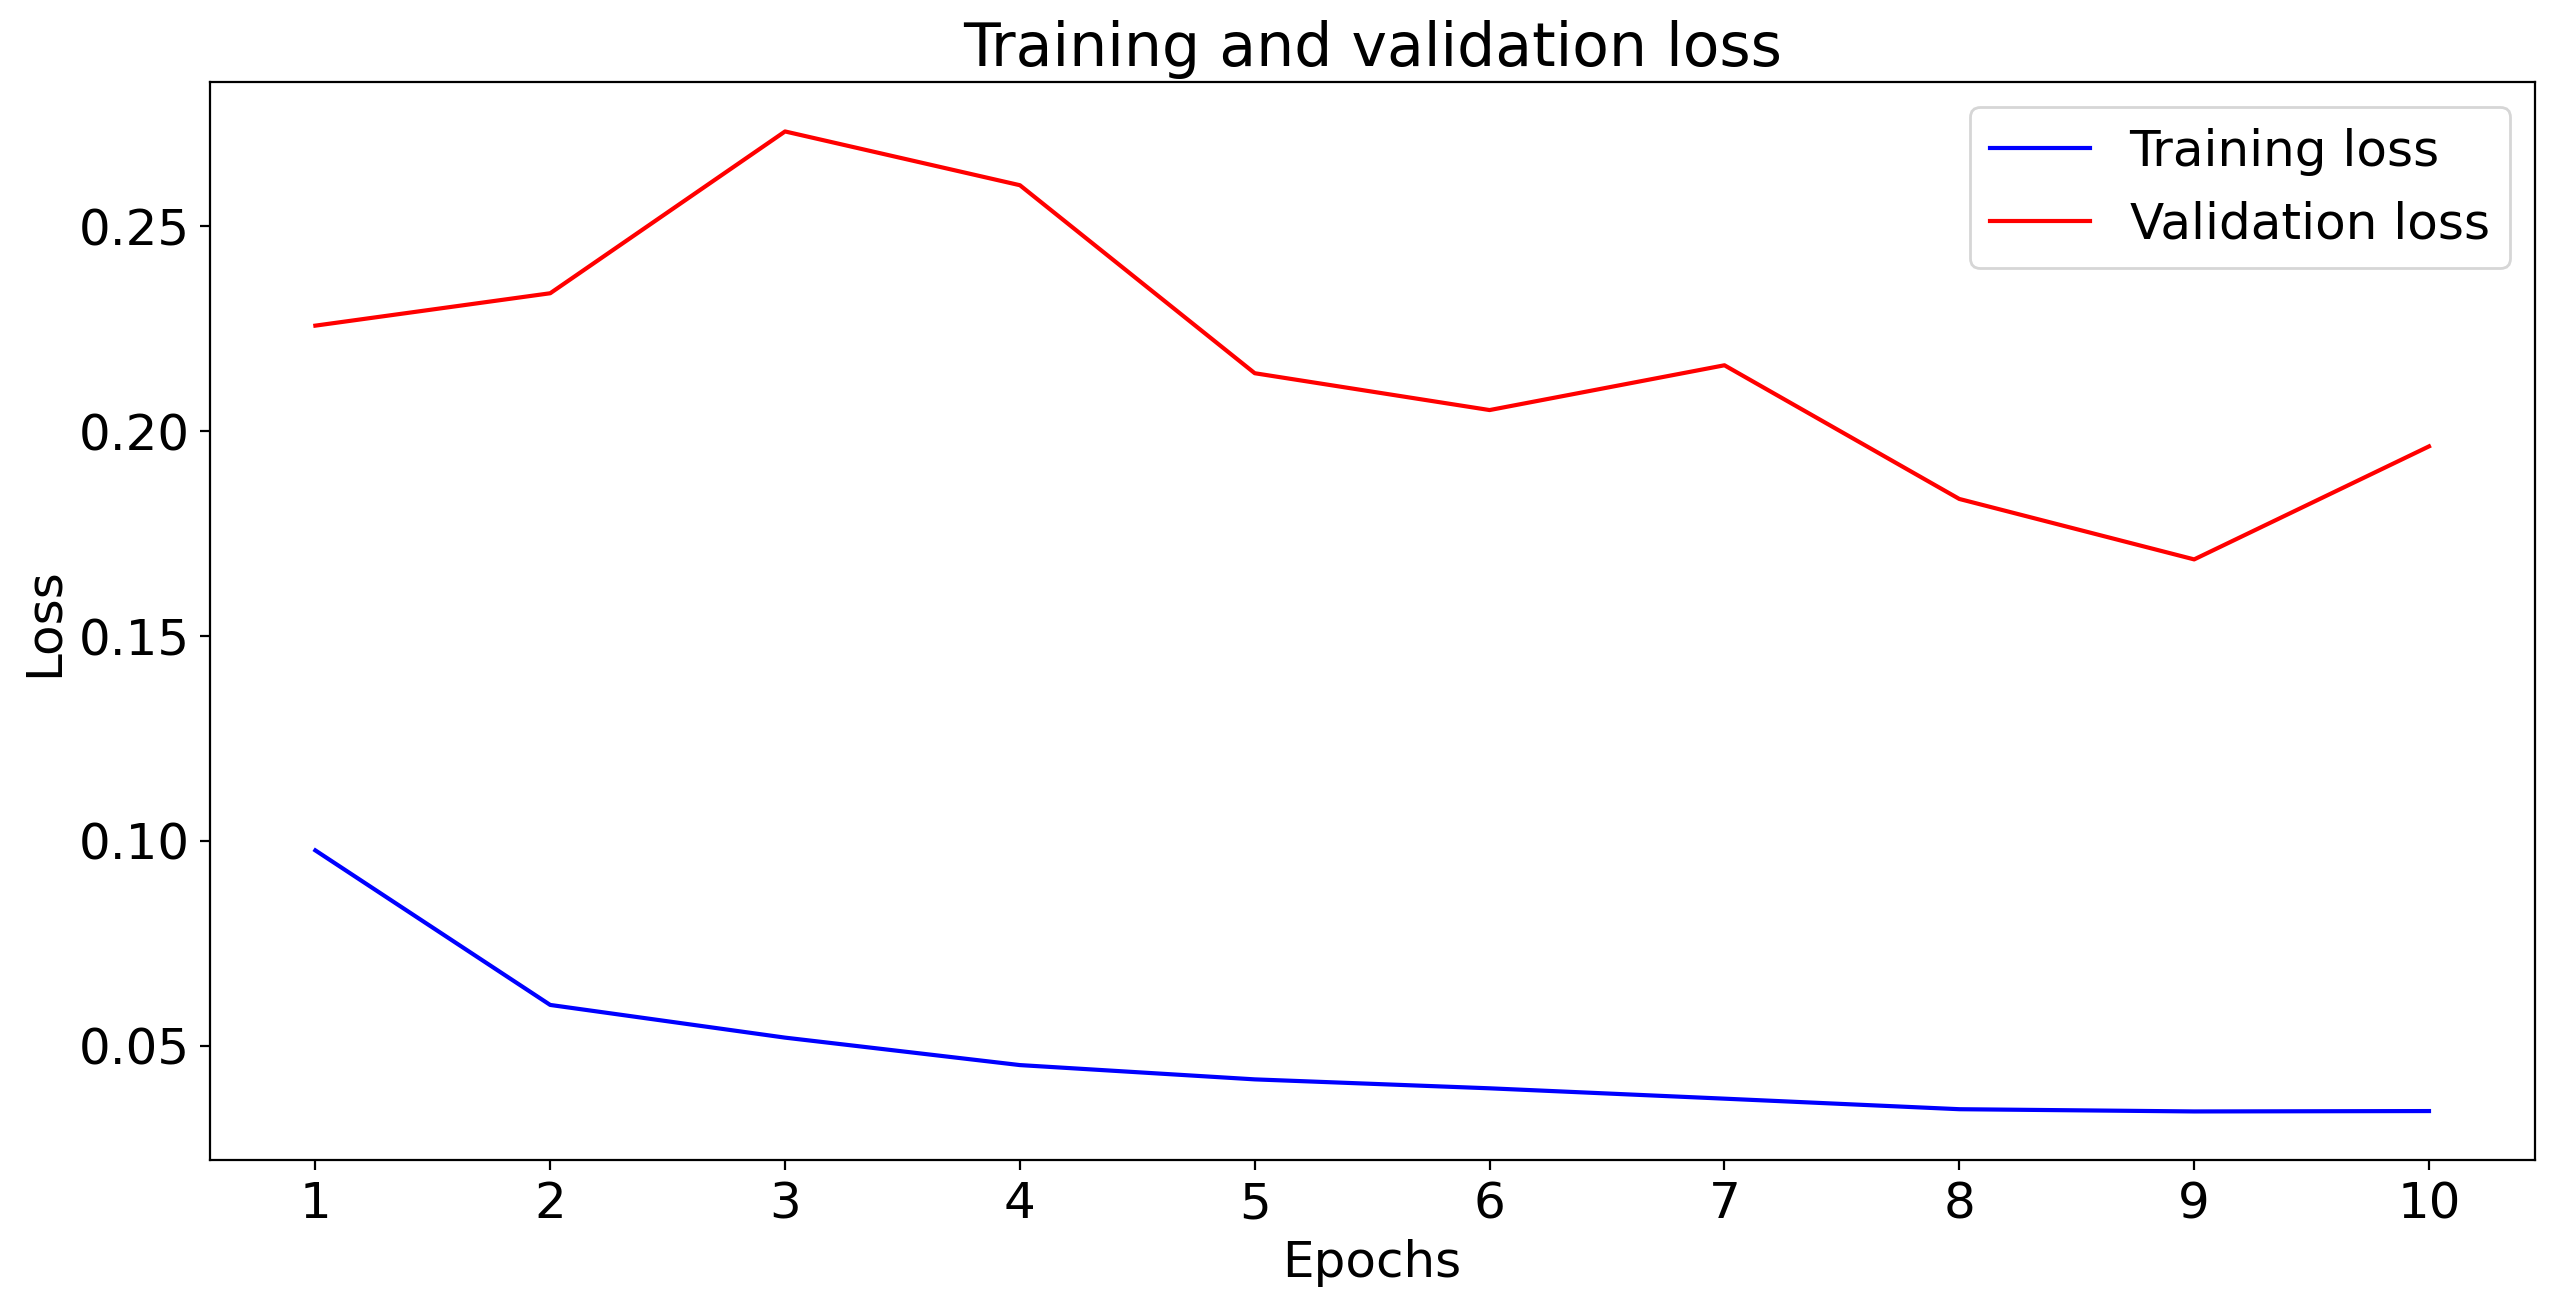

In [43]:
loss_values = history_dict['mae']
val_loss_values = history_dict['val_mae']

loss_values50 = loss_values
val_loss_values50 = val_loss_values
epochs = range(1, len(loss_values50) + 1)
plt.plot(epochs, loss_values50, 'b',color = 'blue', label='Training loss')
plt.plot(epochs, val_loss_values50, 'b',color='red', label='Validation loss')
plt.rc('font', size = 18)
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.xticks(epochs)
fig = plt.gcf()
fig.set_size_inches(15,7)
plt.show()

In [46]:
fig.savefig("loss.png")

In [26]:
y_pred_scaled = model.predict(X_test.values.reshape(-1, 1, X_test.shape[1]))
y_pred_scaled[:5]

4/4 [==============================] - 0s 2ms/step


array([[0.2960928 ],
       [0.28552625],
       [0.33543056],
       [0.2894034 ],
       [0.30713624]], dtype=float32)

In [30]:
import inspect 
# Recall that you applied transformation functions, such as min max scaler and laber encoder. 
# Now you want to transform them back to human readable format.
feature_view.init_serving(1)
# td_transformation_functions = feature_view._single_vector_server._transformation_functions
td_transformation_functions = feature_view._vector_server._transformation_functions

y_pred = pd.DataFrame(y_pred_scaled, columns=["close"])

for feature_name in td_transformation_functions:
    if feature_name == "close":
        td_transformation_function = td_transformation_functions[feature_name]
        sig, foobar_locals = inspect.signature(td_transformation_function.transformation_fn), locals()
        param_dict = dict([(param.name, param.default) for param in sig.parameters.values() if param.default != inspect._empty])
        if td_transformation_function.name == "min_max_scaler":
            y_pred[feature_name] = y_pred[feature_name].map(lambda x: x*(param_dict["max_value"]-param_dict["min_value"])+param_dict["min_value"])
            y_test[feature_name] = y_test[feature_name].map(lambda x: x*(param_dict["max_value"]-param_dict["min_value"])+param_dict["min_value"])

In [31]:
from sklearn.metrics import mean_absolute_error

print("MAE:", mean_absolute_error(y_test, y_pred))

MAE: 7406.38937395346


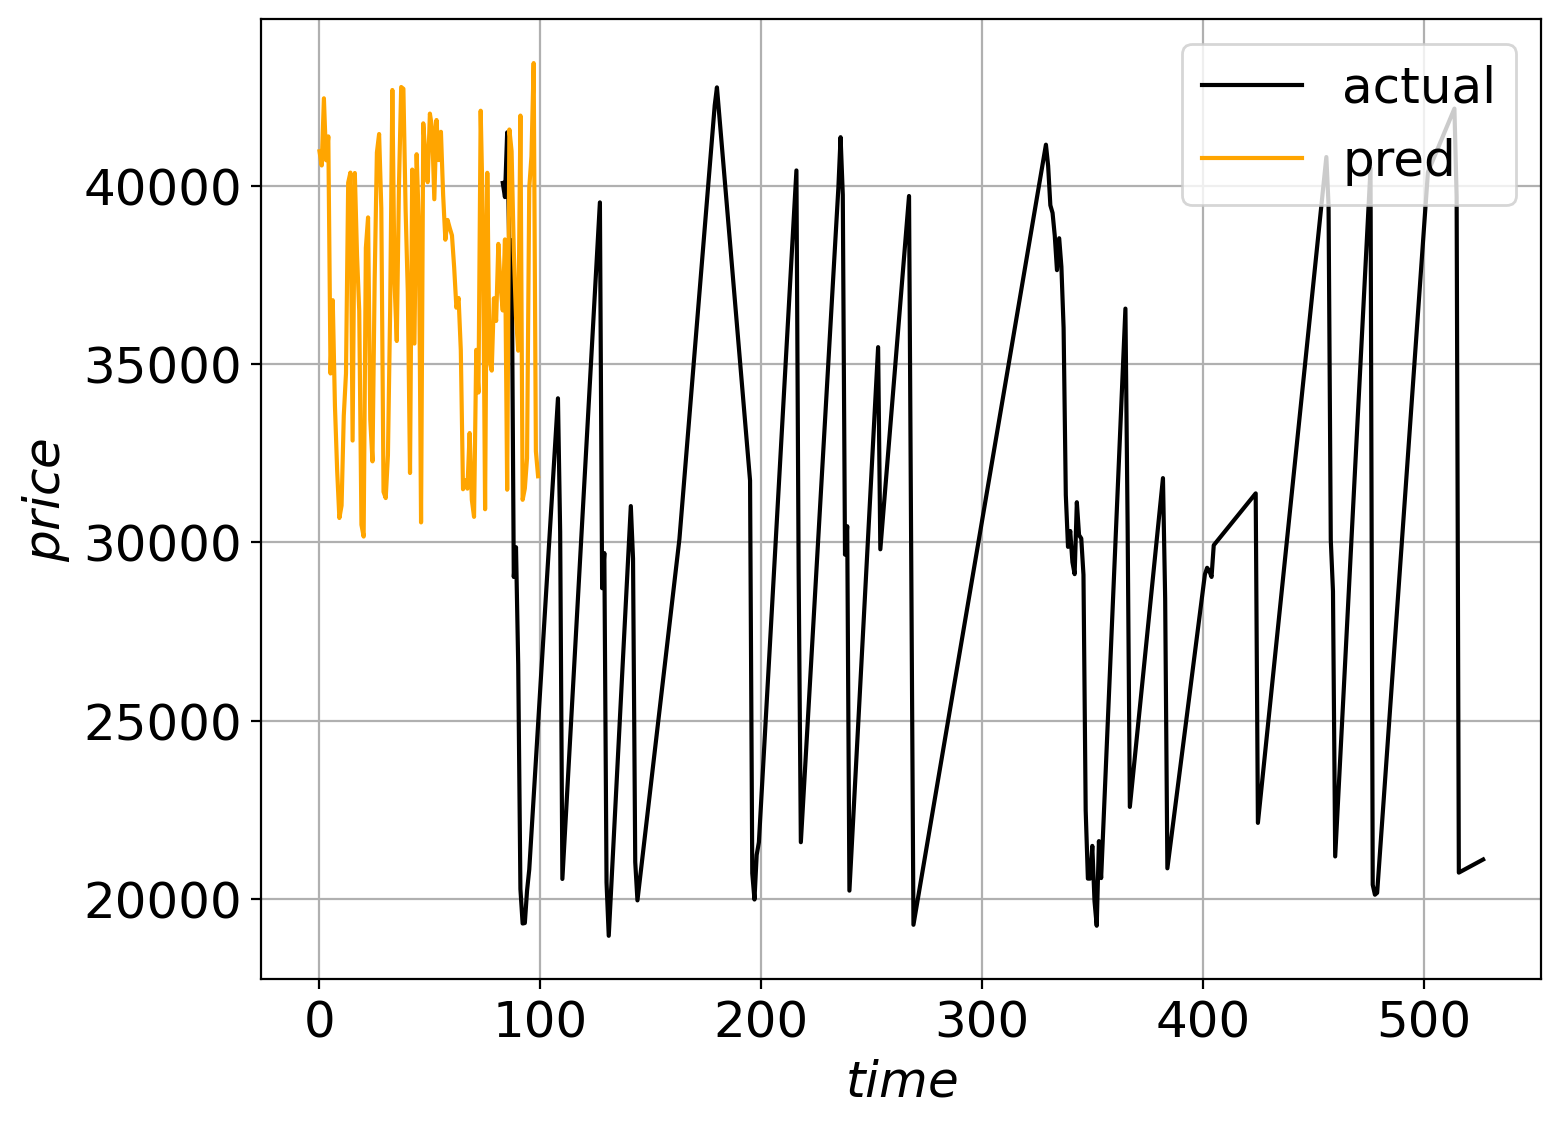

In [32]:
colors = ['darkslategrey']

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.plot(y_test, 'black')
ax.plot(y_pred, 'orange')
ax.set_ylabel('$price$')
ax.set_xlabel('$time$')
ax.grid(True)
ax.legend(["actual", "pred"])

plt.grid(True)
plt.show()

---
## <span style='color:#ff5f27'>🗄 Model Registry</span>

In [33]:
# The 'bitcoin_price_model' directory will be saved to the model registry
model_dir = "bitcoin_price_model"
if not os.path.isdir(model_dir):
    os.mkdir(model_dir)

img_model_dir = model_dir + "/images"
if not os.path.isdir(img_model_dir):
    os.mkdir(model_dir)

fig.savefig(img_model_dir + "/chart.png") 

print('Exporting trained model to: {}'.format(model_dir))
    
tf.saved_model.save(model, model_dir)

Exporting trained model to: bitcoin_price_model
INFO:tensorflow:Assets written to: bitcoin_price_model/assets
INFO:tensorflow:Assets written to: bitcoin_price_model/assets


In [35]:
mr = project.get_model_registry()

metrics={'loss': history_dict['val_mae'][0]} 

today = datetime.datetime.today()
latest_date = int(time.mktime(today.timetuple()) * 1000) # converting todays datetime to unix

tf_model = mr.tensorflow.create_model(
    name="bitcoin_price_model", 
    metrics=metrics,
    input_example=[latest_date],
    description="Bitcoin daily price prediction model.",
)

tf_model.save(model_dir)

Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/53 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/263008 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/50974 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/2796 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/135946 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/15 elapsed<00:00 remaining<?

Model created, explore it at https://127.0.0.1:8181/p/122/models/bitcoin_price_model/1


Model(name: 'bitcoin_price_model', version: 1)

---
## <span style="color:#ff5f27;">🚀 Model Deployment</span>

In [36]:
%%writefile btc_model_transformer.py

import os
import hsfs
import numpy as np

class Transformer(object):
    
    def __init__(self):        
        # get feature store handle
        fs_conn = hsfs.connection()
        self.fs = fs_conn.get_feature_store()
        
        # get feature views
        self.fv = self.fs.get_feature_view("bitcoin_feature_view", 1)
        
        # initialise serving
        self.fv.init_serving(1)

    def flat2gen(self, alist):
        for item in alist:
            if isinstance(item, list):
                for subitem in item: yield subitem
            else:
                yield item
        
    def preprocess(self, inputs):
        feature_vector = self.fv.get_feature_vector({"unix": inputs["instances"][0][0]})
        feature_vector = [*feature_vector[:9], *feature_vector[10:]]
        return { "instances" :  np.array(list(self.flat2gen(feature_vector))).reshape(-1, 1, len(feature_vector)).tolist() }

    def postprocess(self, outputs):
        return outputs

Writing btc_model_transformer.py


In [37]:
from hsml.transformer import Transformer

dataset_api = project.get_dataset_api()

uploaded_file_path = dataset_api.upload("btc_model_transformer.py", "Resources", overwrite=True)
transformer_script_path = os.path.join("/Projects", project.name, uploaded_file_path)
transformer_script = Transformer(script_file=transformer_script_path, resources={"num_instances": 1})

Uploading: 0.000%|          | 0/985 elapsed<00:00 remaining<?

In [38]:
# we can retrieve the model using code like this
tf_model = mr.get_model("bitcoin_price_model", version = 1)

In [39]:
deployment = tf_model.deploy(
    name="btcmodeldeployment",
    transformer=transformer_script,
    resources={"num_instances": 1},
)

Deployment created, explore it at https://127.0.0.1:8181/p/122/deployments/1
Before making predictions, start the deployment by using `.start()`


In [40]:
print("Deployment is warming up...")
time.sleep(40)

Deployment is warming up...


The deployment has now been registered. Lets retrieve it from Hopsworks for demonstration purpose.

In [41]:
ms = project.get_model_serving()

# get deployment object
deployment = ms.get_deployment("btcmodeldeployment")

Connected. Call `.close()` to terminate connection gracefully.


In [51]:
print("Deployment: " + deployment.name)
deployment.describe()

Deployment: btcmodeldeployment
{
    "api_protocol": "REST",
    "artifact_version": 1,
    "batching_configuration": {
        "batching_enabled": false
    },
    "created": "2024-04-20T13:10:36.000Z",
    "creator": "Admin Admin",
    "description": null,
    "id": 1,
    "inference_logging": "NONE",
    "model_framework": "TENSORFLOW",
    "model_name": "bitcoin_price_model",
    "model_path": "/Projects/BinanceFunctionCalling/Models/bitcoin_price_model",
    "model_server": "TENSORFLOW_SERVING",
    "model_version": 1,
    "name": "btcmodeldeployment",
    "predictor": null,
    "predictor_resources": {
        "limits": {
            "cores": 1.0,
            "gpus": 0,
            "memory": 1024
        },
        "requests": {
            "cores": 0.2,
            "gpus": 0,
            "memory": 32
        }
    },
    "requested_instances": 0,
    "requested_transformer_instances": 0,
    "serving_tool": "KSERVE",
    "transformer": "btc_model_transformer.py",
    "transforme

To start it you need to run:

In [52]:
deployment.start(await_running=120)

Deployment is already running
Start making predictions by using `.predict()`


For trouble shooting one can use get_logs method

In [53]:
deployment.get_logs()

Explore all the logs and filters in the Kibana logs at https://127.0.0.1:8181/p/122/deployments/1

Instance name: btcmodeldeployment-predictor-00002-deployment-69f9f74c66-wg555
2024-04-20 13:19:34.135983: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:305] SavedModel load for tags { serve }; Status: success: OK. Took 334405 microseconds.
2024-04-20 13:19:34.138551: I tensorflow_serving/servables/tensorflow/saved_model_warmup_util.cc:62] No warmup data file found at /mnt/models/1/assets.extra/tf_serving_warmup_requests
2024-04-20 13:19:34.693473: I tensorflow_serving/core/loader_harness.cc:95] Successfully loaded servable version {name: btcmodeldeployment version: 1}
2024-04-20 13:19:34.698409: I tensorflow_serving/model_servers/server_core.cc:486] Finished adding/updating models
2024-04-20 13:19:34.698481: I tensorflow_serving/model_servers/server.cc:118] Using InsecureServerCredentials
2024-04-20 13:19:34.698497: I tensorflow_serving/model_servers/server.cc:383] Profile

---
## <span style="color:#ff5f27;">🔮 Predicting</span>

Using the deployment let's use the input example that we registered together with the model to query the deployment.

In [54]:
today = datetime.datetime.today()
latest_date = int(time.mktime(today.timetuple()) * 1000) # converting todays datetime to unix

deployment_output = deployment.predict(inputs=[latest_date])
# or deployment.predict({ "instances": [[latest_date]] })

deployment_output

RestAPIError: Metadata operation error: (url: http://127.0.0.1:32080/v1/models/btcmodeldeployment:predict). Server response: 
HTTP code: 500, HTTP reason: Internal Server Error, body: b'{"error":"HTTPError : HTTP 500: Feature \'open\' is missing from vector.Possible reasons: 1. There is no match in the given entry. Please check if the entry exists in the online feature store or provide the feature as passed_feature. 2. Required entries [unix] or [unix] are not provided."}', error code: , error msg: , user msg: 

 Check the model server logs by using `.get_logs()`

In [ ]:
pred_encoded = pd.DataFrame(
    deployment_output["predictions"],
    columns=["close"],
) # since we applied transformation function to the 'close' columns,
  # now we need to provide a df with the same column name to decode.
                                                
pred = decode_features(pred_encoded, feature_view=feature_view)

In [ ]:
pred = pred.rename(columns={"close": "predicted_price"})
pred["datetime"] = [today.strftime("%Y-%m-%d")]

In [ ]:
pred

In [ ]:
# # For trouble shooting one you can use get_logs method.
# deployment.get_logs()

---
## <span style="color:#ff5f27;"> ✨ Load Batch Data of last days</span>

In [ ]:
feature_view.init_batch_scoring(1)

batch_data = feature_view.get_batch_data().drop('unix',axis=1)
batch_data.head()

In [ ]:
model = mr.get_model("bitcoin_price_model", version=1)
model_dir = model.download()

loaded_model = tf.saved_model.load(model_dir)
serving_function = loaded_model.signatures["serving_default"]

In [ ]:
predictions_batch = serving_function(
    tf.constant(
        batch_data.values.reshape(
            -1, 
            batch_data.shape[0], 
            batch_data.shape[1]), 
        tf.float32
    )
)['dense_1'].numpy()

Recall that you applied transformation functions, such as min max scaler and laber encoder. 

Now you want to transform them back to human readable format.

In [ ]:
pred_batch_encoded = pd.DataFrame(
    predictions_batch,
    columns=["close"]
) # since we applied transformation function to the 'close' columns,
  # now we need to provide a df with the same column name to decode.
                                                
pred_batch = decode_features(pred_batch_encoded, feature_view=feature_view)

In [ ]:
pred_batch.tail(5)

---
## <span style="color:#ff5f27;"> ⏭️ **Next:** Part 04: Batch Inference</span>

In the following notebook you will use your model for Batch Inference.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/logicalclocks/hopsworks-tutorials/blob/master/bitcoin/4_bitcoin_batch_inference.ipynb)